In [1]:
pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
#from tensorflow.keras.layers.experimental import preprocessing
from pathlib import Path
import os.path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os

In [3]:
import warnings
warnings.filterwarnings('ignore')

# load train and validation and test data

In [4]:
train = r'/kaggle/input/oil-spill-dataset-binary-image-classification/final dataset used for oil spill/dataset-final/dataset/train'
validation = r'/kaggle/input/oil-spill-dataset-binary-image-classification/final dataset used for oil spill/dataset-final/dataset/Validation'
test =r'/kaggle/input/oil-spill-dataset-binary-image-classification/final dataset used for oil spill/dataset-final/dataset/test'

# read our folders in train

In [5]:
# Directories for Non Oil Spill and Oil Spill images
non_oil_spill_dir = os.path.join(train, 'Non Oil Spill')
oil_spill_dir = os.path.join(train, 'Oil Spill')


# Size of image before

In [6]:
labels = ['Non Oil Spill', 'Oil Spill']

for label in labels:
    path = os.path.join( r'/kaggle/input/oil-spill-dataset-binary-image-classification/final dataset used for oil spill/dataset-final/dataset/train')
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path)

        if img_arr is not None:
            print(f"Original size of image {img}: {img_arr.shape}") 

# change size to 150

In [7]:
labels = ['Non Oil Spill', 'Oil Spill']
img_size = 150
data = []

for label in labels: 
    path = os.path.join(r'/kaggle/input/oil-spill-dataset-binary-image-classification/final dataset used for oil spill/dataset-final/dataset/train', label)  
    class_num = labels.index(label)

    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path)

        if img_arr is not None: 
            img_arr = cv2.resize(img_arr, (img_size, img_size))  
            data.append([img_arr, class_num])  


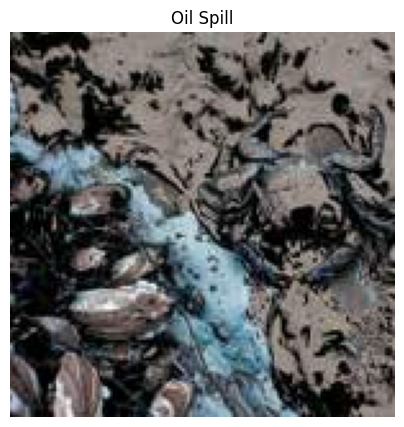

Size of image 1: (150, 150, 3)


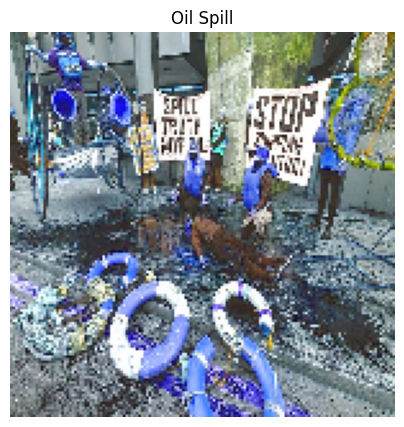

Size of image 2: (150, 150, 3)


In [8]:
count=0
for i in range(len(data)):
    if data[i][1] == 1: 
        plt.figure(figsize=(5, 5))
        plt.imshow(data[i][0])  
        plt.title(labels[data[i][1]])  
        plt.axis('off')  
        plt.show()
        
        print(f"Size of image {count + 1}: {data[i][0].shape}")
        
        count += 1  
        
        if count == 2:  
            break

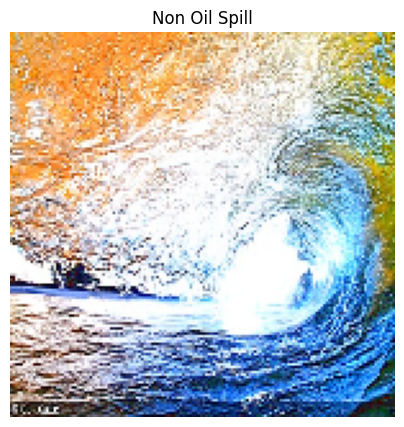

Size of image 1: (150, 150, 3)


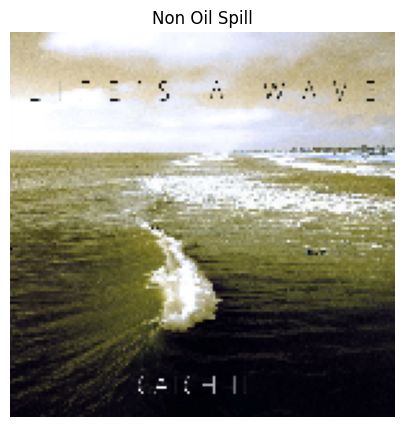

Size of image 2: (150, 150, 3)


In [9]:
data = np.array(data, dtype=object)

for i in range(2):
    plt.figure(figsize=(5, 5))
    plt.imshow(data[i][0])  
    plt.title(labels[data[i][1]])  
    plt.axis('off')  
    plt.show()
    
    print(f"Size of image {i + 1}: {data[i][0].shape}")


# create a function that resize the image 

In [10]:
def load_data(directory):
    data = []
    for label in labels: 
        path = os.path.join(directory, label)  
        class_num = labels.index(label)

        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            img_arr = cv2.imread(img_path)

            if img_arr is not None: 
                img_arr = cv2.resize(img_arr, (img_size, img_size))  
                data.append([img_arr, class_num])  
    return np.array(data, dtype=object)

In [11]:
train_data = load_data(train)
test_data = load_data(test)
validation_data = load_data(validation)

In [12]:
print("Shape of training data:", train_data.shape)
print("Shape of test data:", test_data.shape)
print("Shape of valdata:", validation_data.shape)

Shape of training data: (2800, 2)
Shape of test data: (600, 2)
Shape of valdata: (600, 2)


In [13]:
# Function to populate features and labels from data
def populate_data(data):
    features, labels = zip(*data) 
    return np.array(features) / 255.0, np.array(labels) 

In [14]:
x_train, y_train = populate_data(train_data)
x_val, y_val = populate_data(load_data(validation))  
x_test, y_test = populate_data(load_data(test))    

In [15]:
print("Shapes:")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

Shapes:
x_train: (2800, 150, 150, 3), y_train: (2800,)
x_val: (600, 150, 150, 3), y_val: (600,)
x_test: (600, 150, 150, 3), y_test: (600,)


In [16]:
datagen = ImageDataGenerator(
    rotation_range=90,          
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    horizontal_flip=True         
)

In [17]:
datagen.fit(x_train)
datagen.fit(x_val)
datagen.fit(x_test)

# base model 

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       175,233 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,129 (688.00 KB)

 Trainable params: 176,129 (688.00 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), shuffle=True, batch_size=64)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 625ms/step - accuracy: 0.6335 - loss: 1.1875 - val_accuracy: 0.8333 - val_loss: 0.3724
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 617ms/step - accuracy: 0.9012 - loss: 0.2672 - val_accuracy: 0.9317 - val_loss: 0.1986
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 629ms/step - accuracy: 0.9713 - loss: 0.1107 - val_accuracy: 0.9400 - val_loss: 0.1474
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 624ms/step - accuracy: 0.9850 - loss: 0.0660 - val_accuracy: 0.9783 - val_loss: 0.0844
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 622ms/step - accuracy: 0.9919 - loss: 0.0437 - val_accuracy: 0.9817 - val_loss: 0.0663
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 615ms/step - accuracy: 0.9982 - loss: 0.0278 - val_accuracy: 0.9900 - val_loss: 0.0494
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 596ms/step - accuracy: 0.9990 - loss: 0.0171 - val_accuracy: 0.9883 - val_loss: 0.0446
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 604ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accu

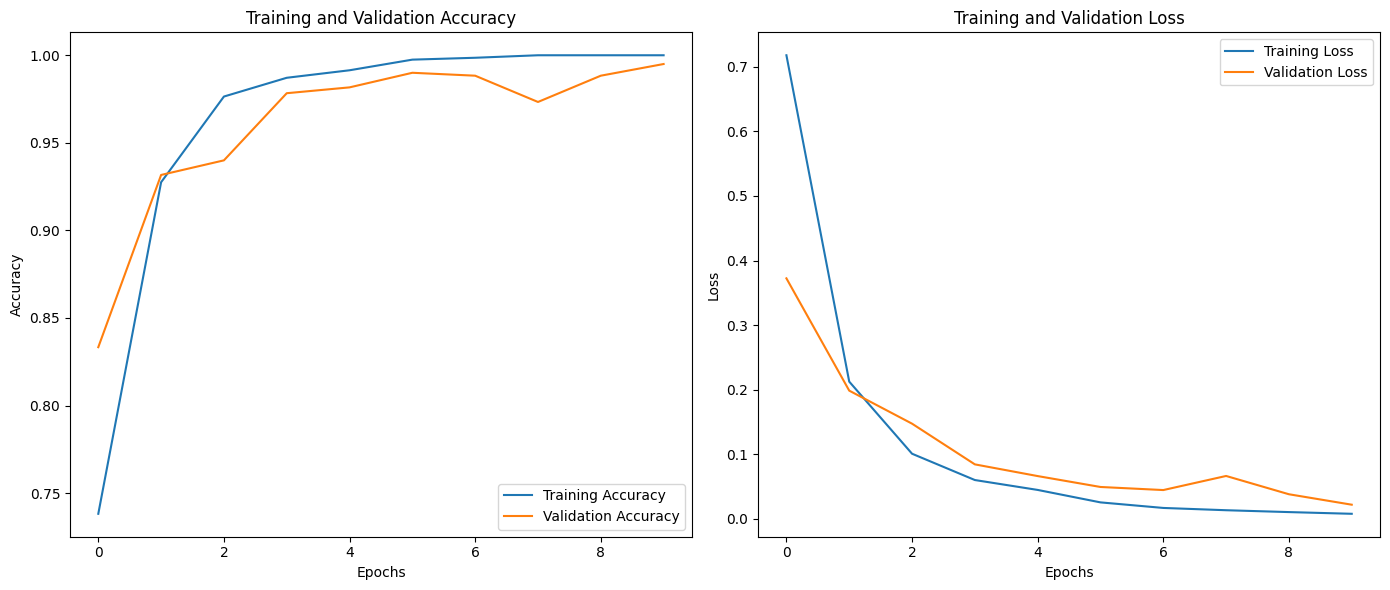

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(train_accuracy, label='Training Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(train_loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import classification_report
y_pred_test = (model.predict(x_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred_test))


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [22]:
model.evaluate(x_test,y_test,batch_size=64)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.9995 - loss: 0.0119


[0.01469678245484829, 0.9983333349227905]

# build a model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D

model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3), padding="same"))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))


model.add(Dense(1, activation="sigmoid"))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        41,473 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,721 (526.25 KB)

 Trainable params: 134,721 (526.25 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), shuffle=True, batch_size=64)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.5810 - loss: 0.6913 - val_accuracy: 0.6383 - val_loss: 0.6273
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7427 - loss: 0.5215 - val_accuracy: 0.8200 - val_loss: 0.4352
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8638 - loss: 0.3303 - val_accuracy: 0.8533 - val_loss: 0.3345
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8963 - loss: 0.2655 - val_accuracy: 0.8600 - val_loss: 0.3187
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9547 - loss: 0.1473 - val_accuracy: 0.8750 - val_loss: 0.2800
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9513 - loss: 0.1257 - val_accuracy: 0.9300 - val_loss: 0.1540
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9825 - loss: 0.0774 - val_accuracy: 0.9467 - val_loss: 0.1479
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9776 - loss: 0.0688 - val_accuracy: 0.9700 - val_loss:

In [25]:
y_pred_test = (model.predict(x_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_test))


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       300
           1       1.00      0.96      0.98       300

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



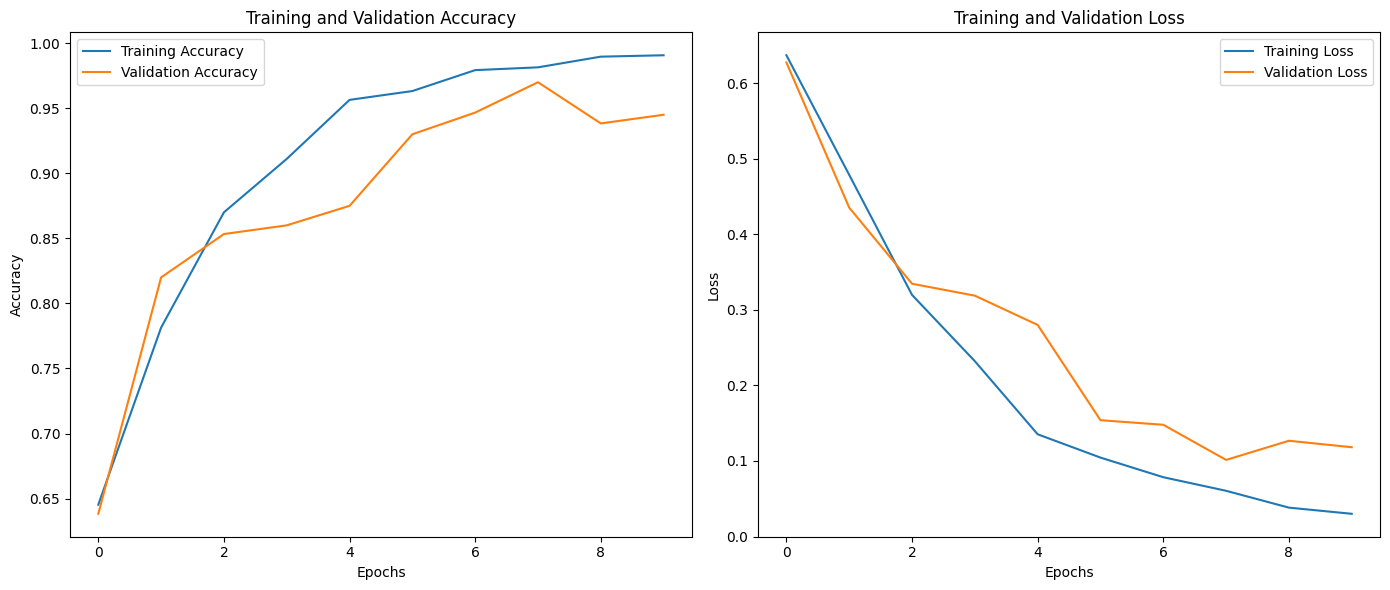

In [26]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(train_accuracy, label='Training Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(train_loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


# predict and test

In [27]:
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array

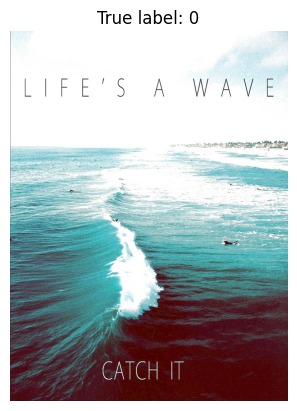

In [28]:
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = img_to_array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  #
    return img_array

# Path to your image and its true label
image_path = '/kaggle/input/oil-spill-dataset-binary-image-classification/final dataset used for oil spill/dataset-final/dataset/test/Non Oil Spill/AUG_Non_oil_spill00150.jpg'  # Replace with your image path
true_label = 0 
plt.imshow(Image.open(image_path))
plt.axis('off')  # Hide the axis
plt.title(f"True label: {true_label}")
plt.show()

In [29]:
processed_image = load_and_preprocess_image(image_path)
prediction = model.predict(processed_image)
predicted_class = (prediction > 0.5).astype("int32")  
print("Predicted class:", predicted_class[0][0])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class: 0


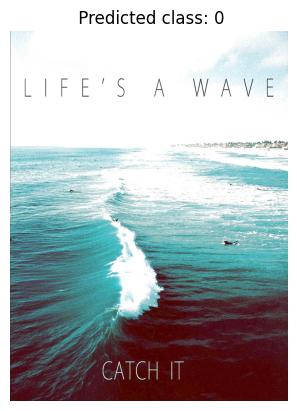

In [30]:
# Display the image
plt.imshow(Image.open(image_path))
plt.axis('off')  # Hide the axis
plt.title(f" Predicted class: {predicted_class[0][0]}")
plt.show()